In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import multivariate_normal
from sklearn.naive_bayes import GaussianNB

In [41]:
df = pd.read_csv('20.csv')
numberOfAttributes = len(df.columns)
print(f'Number of attributes {numberOfAttributes}')
print('shape of the set ', df.shape)
df

Number of attributes 10
shape of the set  (5000, 10)


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
...,...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,116.0,126.7,45.5,25.7,2.11,2.8,765,Hazardous
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709,Moderate
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379,Moderate
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241,Good


## --> COUNTING THE NUMBER OF SAMPLES IN EACH CLASS AND CHECKING FOR MISSING VALUES

In [42]:
moderate_count = 0
Good_count = 0
Hazardous_count = 0
poor_count = 0
for i in range(len(df['Air Quality'])):
    if df['Air Quality'][i] == 'Moderate':
        moderate_count = moderate_count + 1
    elif df['Air Quality'][i] == 'Good':
        Good_count = Good_count + 1
    elif df['Air Quality'][i] == 'Hazardous':
        Hazardous_count = Hazardous_count + 1
    else :
        poor_count = poor_count + 1
    
print(f'Number of samples that are moderate pollution are {moderate_count}')
print(f'Number of samples that have good pollution are {Good_count}')
print(f'Number of samples that have Hazardous pollution are {Hazardous_count}')
print(f'Number of samples that have poor pollution are {poor_count}')
print("**"*50)
for col in df.columns:
    missing_values = df[col].isnull().sum()
    print(f'The number of missing values are {missing_values} for {col}')

Number of samples that are moderate pollution are 1500
Number of samples that have good pollution are 2000
Number of samples that have Hazardous pollution are 500
Number of samples that have poor pollution are 1000
****************************************************************************************************
The number of missing values are 0 for Temperature
The number of missing values are 0 for Humidity
The number of missing values are 0 for PM2.5
The number of missing values are 0 for PM10
The number of missing values are 0 for NO2
The number of missing values are 0 for SO2
The number of missing values are 0 for CO
The number of missing values are 0 for Proximity_to_Industrial_Areas
The number of missing values are 0 for Population_Density
The number of missing values are 0 for Air Quality


## --> PLOTTING THE DISTRIBUTION OF CLASSES

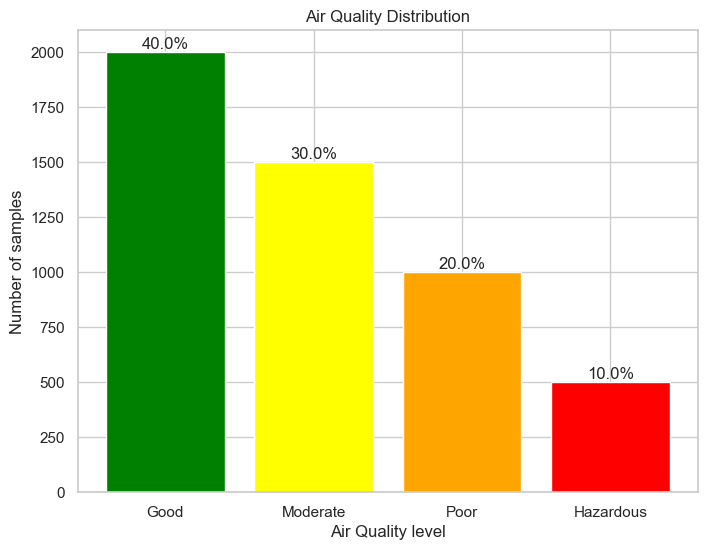

In [43]:
pollution_counts = {
    "Good" : Good_count,
    "Moderate" : moderate_count,
    "Poor" : poor_count,
    "Hazardous" : Hazardous_count
}
total_count = sum(pollution_counts.values())
percentages = []
for count in pollution_counts.values():
    percentage = (count / total_count) * 100
    percentages.append(percentage)
plt.figure(figsize=(8, 6))
bars = plt.bar(pollution_counts.keys(),pollution_counts.values(),color = ['green','yellow','orange','red'])

for bar,percentage in zip(bars,percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,f'{percentage:.1f}%', ha='center', va='bottom')
    
plt.xlabel('Air Quality level')
plt.ylabel('Number of samples')
plt.title('Air Quality Distribution')
plt.show()

## --> ENCODING CATEGORICAL VARIABLES FOR CLASSIFICATION

In [44]:
data=df.copy()
mapping = {
    "Good" : 0,
    "Moderate" : 1,
    "Poor" : 2,
    "Hazardous" : 3
}
data['Air Quality'] = df['Air Quality'].map(mapping)
data.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,1
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,1
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,1
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,0
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,0


In [45]:
df_columns = data[["Temperature","Humidity","PM2.5","PM10","NO2","SO2","CO","Proximity_to_Industrial_Areas","Population_Density"]]
df_columns.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


## --> BOX PLOT FOR VISUALIZING OUTLIERS

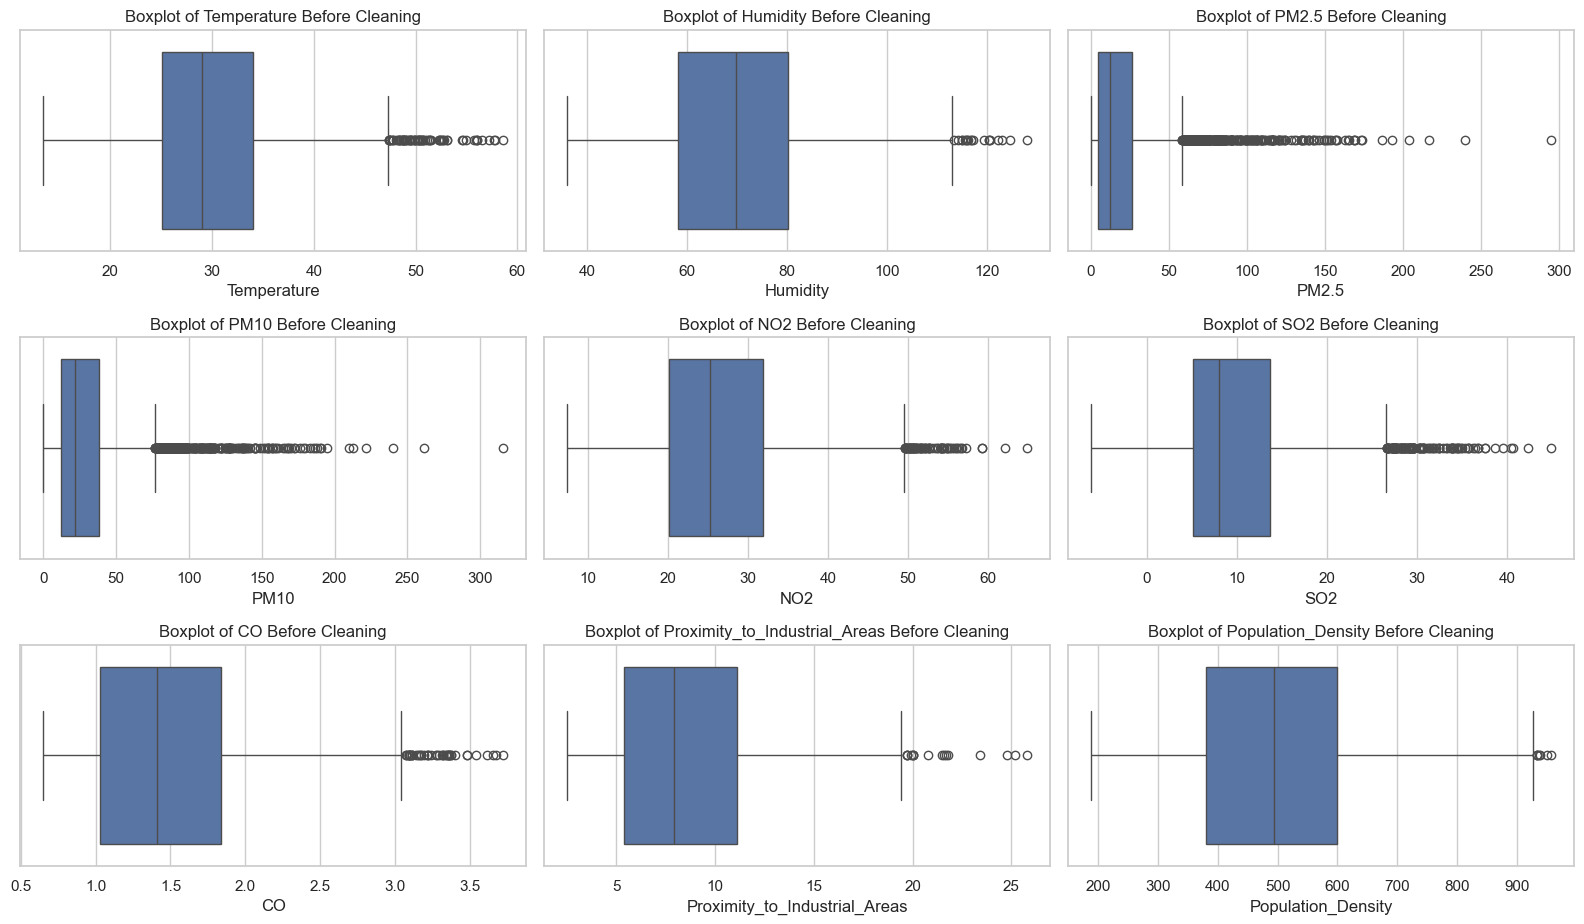

In [46]:
plt.figure(figsize=(16, 12))
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col} Before Cleaning')
    plt.tight_layout()

plt.show()


# Number of Outliers

In [47]:
for col in df_columns.columns:
    Q1 = df_columns[col].quantile(0.25)
    Q3 = df_columns[col].quantile(0.75)

    IQR = Q3- Q1
    minimum_range = Q1 - 1.5* IQR
    maximum_range = Q3 + 1.5* IQR

    outliers = ((df[col] < minimum_range) | (df[col] > maximum_range))
    print(f'The Number of outliers in {col} is {outliers.sum()}')

The Number of outliers in Temperature is 72
The Number of outliers in Humidity is 19
The Number of outliers in PM2.5 is 352
The Number of outliers in PM10 is 324
The Number of outliers in NO2 is 73
The Number of outliers in SO2 is 124
The Number of outliers in CO is 45
The Number of outliers in Proximity_to_Industrial_Areas is 16
The Number of outliers in Population_Density is 7


# Negative Values

In [48]:
pollutant_cols = ['PM2.5','PM10','NO2','SO2','CO']
for col in pollutant_cols:
    num_neg = (df_columns[col] < 0).sum()
    print(f"{col}: {num_neg} negative value(s)")
#Clip negative values with lower bound
for col in df_columns.columns:
    df_columns.loc[:, col] = df_columns[col].clip(lower=0)

# Clip Humidity upper bound
df_columns.loc[:, 'Humidity'] = df_columns['Humidity'].clip(upper=100)
df_columns.describe()

PM2.5: 0 negative value(s)
PM10: 1 negative value(s)
NO2: 0 negative value(s)
SO2: 30 negative value(s)
CO: 0 negative value(s)


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,69.810180,20.142140,30.218400,26.412100,10.020720,1.500354,8.425400,497.423800
std,6.720661,15.301732,24.554546,27.349155,8.895356,6.740247,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,0.000000,7.400000,0.000000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,100.000000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


# Observing the distribution

Index(['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO',
       'Proximity_to_Industrial_Areas', 'Population_Density'],
      dtype='object')


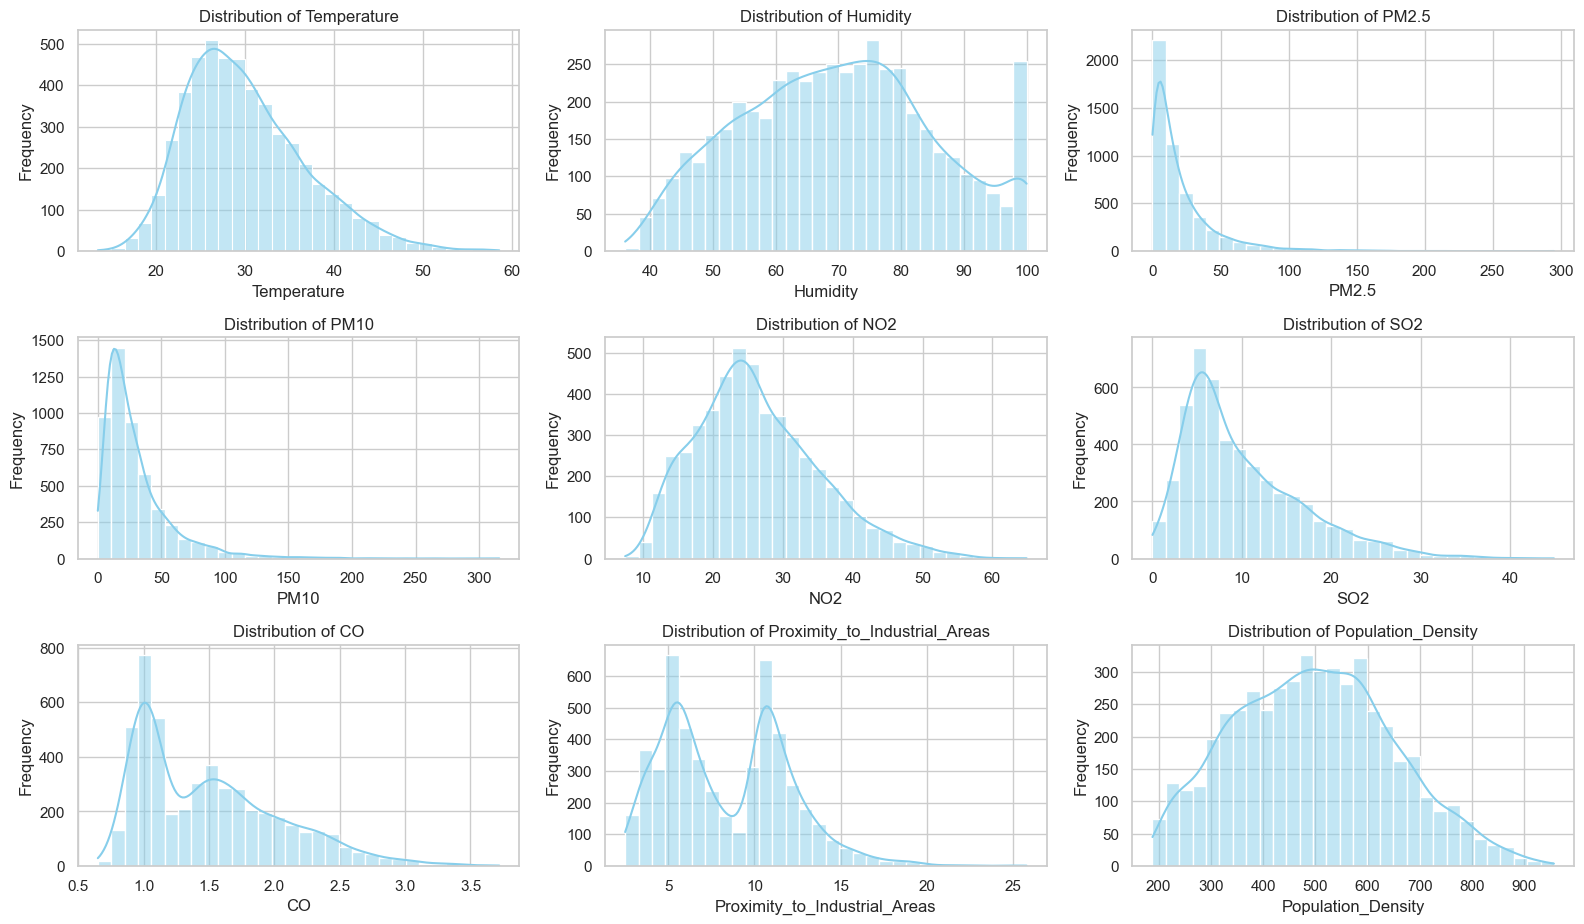

In [49]:
sns.set(style="whitegrid")
print(df_columns.columns)
# Loop through each column
plt.figure(figsize=(16, 12))
for i,col in enumerate(df_columns.columns,1):
    plt.subplot(4, 3, i)
    sns.histplot(df_columns[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
plt.show()

# APPLYING LOG TRANSFORMATION

In [50]:
for col in pollutant_cols:
    df_columns.loc[:,col] = np.log1p(df_columns.loc[:,col])
df_columns.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,69.810180,2.503360,3.143141,3.258198,2.212599,0.894260,8.425400,497.423800
std,6.720661,15.301732,1.090685,0.769075,0.328493,0.636790,0.207284,3.610944,152.754084
min,13.400000,36.000000,0.000000,0.000000,2.128232,0.000000,0.500775,2.500000,188.000000
25%,25.100000,58.300000,1.722767,2.587764,3.049273,1.808289,0.708036,5.400000,381.000000
50%,29.000000,69.800000,2.564949,3.122365,3.269569,2.197225,0.879627,7.900000,494.000000
75%,34.000000,80.300000,3.299534,3.666122,3.493473,2.689542,1.043804,11.100000,600.000000
max,58.600000,100.000000,5.690359,5.758271,4.188138,3.826465,1.551809,25.800000,957.000000


In [51]:
for col in df_columns.columns:
    Q1 = df_columns[col].quantile(0.25)
    Q3 = df_columns[col].quantile(0.75)

    IQR = Q3- Q1
    minimum_range = Q1 - 1.5* IQR
    maximum_range = Q3 + 1.5* IQR

    outliers = ((df_columns[col] < minimum_range) | (df_columns[col] > maximum_range))
    print(f'The Number of outliers in {col} is {outliers.sum()}')

The Number of outliers in Temperature is 72
The Number of outliers in Humidity is 0
The Number of outliers in PM2.5 is 1
The Number of outliers in PM10 is 14
The Number of outliers in NO2 is 6
The Number of outliers in SO2 is 64
The Number of outliers in CO is 1
The Number of outliers in Proximity_to_Industrial_Areas is 16
The Number of outliers in Population_Density is 7


In [52]:
outlier_cols = ['Temperature','PM2.5','PM10','NO2','SO2']
for col in outlier_cols:
    Q1 = df_columns[col].quantile(0.25)
    Q3 = df_columns[col].quantile(0.75)

    IQR = Q3- Q1
    minimum_range = Q1 - 1.5* IQR
    maximum_range = Q3 + 1.5* IQR

    outliers = ((df_columns[col] < minimum_range) | (df_columns[col] > maximum_range))
    mean= df_columns.loc[~outliers,col].mean()
    df_columns.loc[outliers,col] = mean

# Outliers After Cleaning

In [53]:
for col in df_columns.columns:
    Q1 = df_columns[col].quantile(0.25)
    Q3 = df_columns[col].quantile(0.75)

    IQR = Q3- Q1
    minimum_range = Q1 - 1.5* IQR
    maximum_range = Q3 + 1.5* IQR

    outliers = ((df_columns[col] < minimum_range) | (df_columns[col] > maximum_range))
    print(f'The Number of outliers in {col} is {outliers.sum()}')

The Number of outliers in Temperature is 24
The Number of outliers in Humidity is 0
The Number of outliers in PM2.5 is 0
The Number of outliers in PM10 is 1
The Number of outliers in NO2 is 0
The Number of outliers in SO2 is 0
The Number of outliers in CO is 1
The Number of outliers in Proximity_to_Industrial_Areas is 16
The Number of outliers in Population_Density is 7


## --> BOX PLOTS AFTER CLEANING

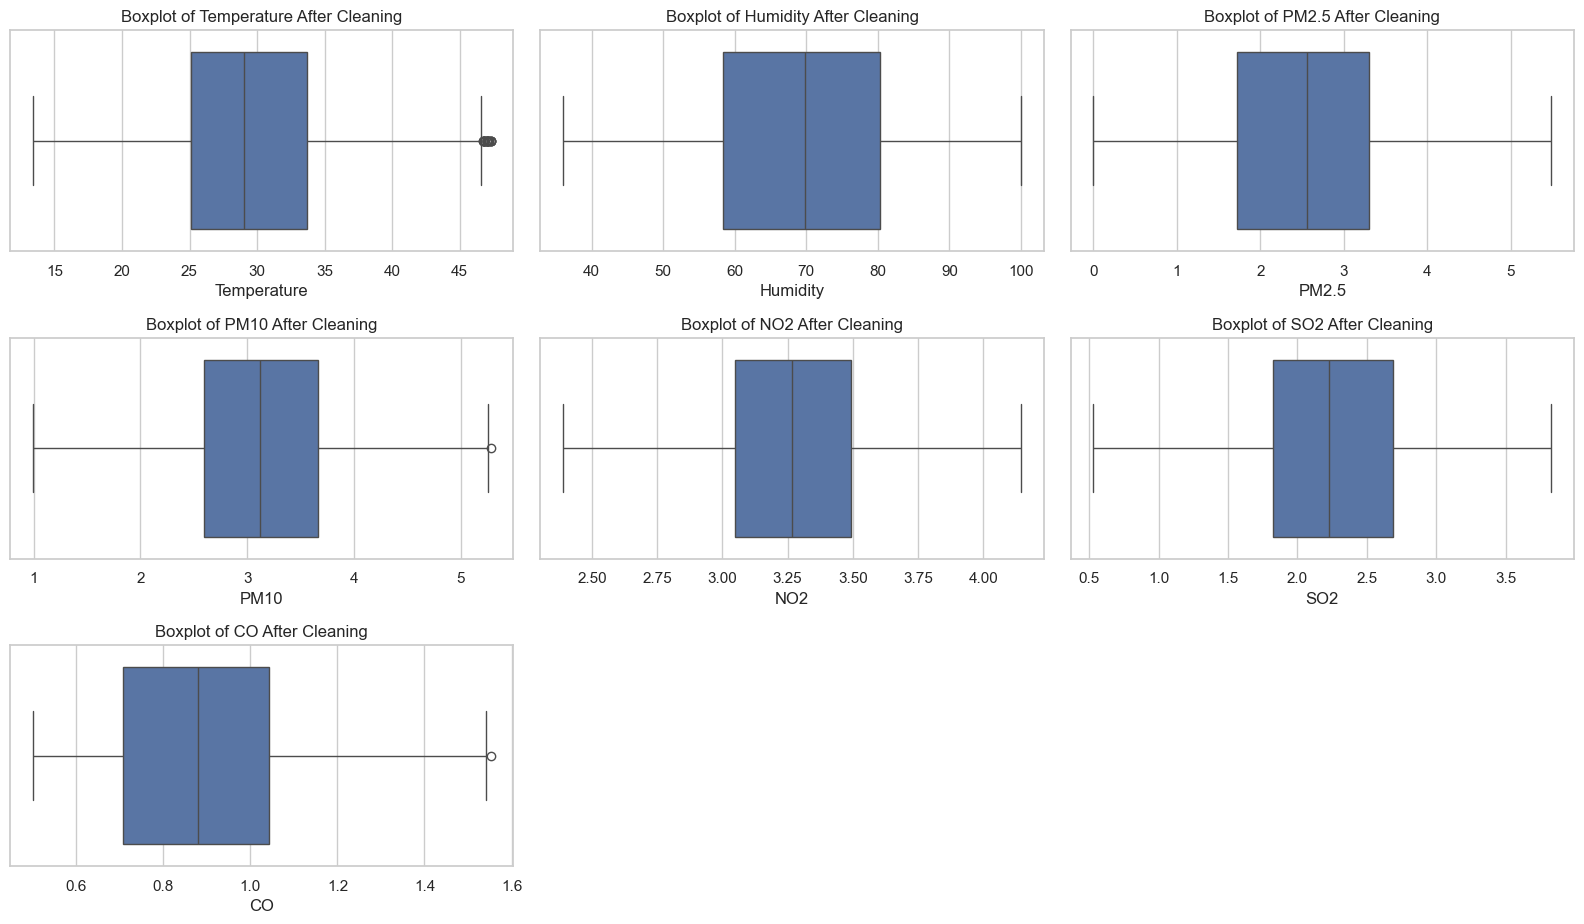

In [54]:
plt.figure(figsize=(16, 12))
numerical_cols = df_columns.select_dtypes(include=['float64', 'int64']).columns
for i, col in enumerate(numerical_cols, 1):
    if col not in ['Proximity_to_Industrial_Areas','Population_Density']:
        plt.subplot(4, 3, i)
        sns.boxplot(data=df_columns, x=col)
        plt.title(f'Boxplot of {col} After Cleaning')
        plt.tight_layout()

plt.show()


# Visualizing the Heat map

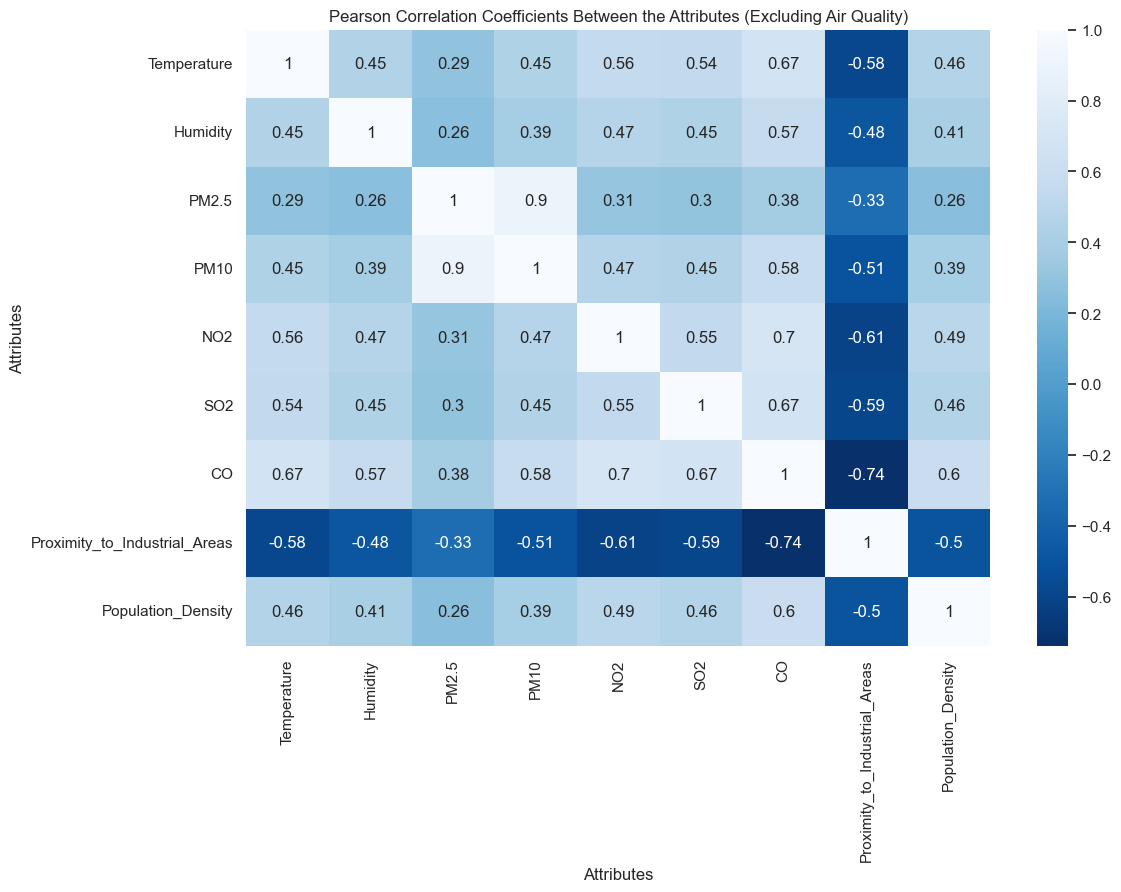

In [55]:
# Calculate Pearson correlation
pearson = df_columns.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pearson, annot=True, cmap='Blues_r')
plt.xlabel('Attributes')
plt.ylabel('Attributes')
plt.title('Pearson Correlation Coefficients Between the Attributes (Excluding Air Quality)')
plt.show()

# Observing Class Imbalance

In [56]:
print(df['Air Quality'].value_counts())
print(data['Air Quality'].value_counts())
df_columns['Air Quality'] = data['Air Quality']


X = df_columns.iloc[:,:9]
y = df_columns.iloc[:,9]

Air Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64
Air Quality
0    2000
1    1500
2    1000
3     500
Name: count, dtype: int64


In [57]:
X_train , X_temp, y_train, y_temp = train_test_split(X, y, random_state=42,test_size=0.4, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, random_state=42, test_size= 0.5,stratify=y_temp)
y_train.value_counts()

Air Quality
0    1200
1     900
2     600
3     300
Name: count, dtype: int64

# Applying SMOTE to Remove the Class Imbalance

In [58]:
print(y_train.value_counts())

# oversampling the train dataset using SMOTE
smt = SMOTE(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

print(y_train.value_counts())


Air Quality
0    1200
1     900
2     600
3     300
Name: count, dtype: int64
Air Quality
2    1200
3    1200
0    1200
1    1200
Name: count, dtype: int64


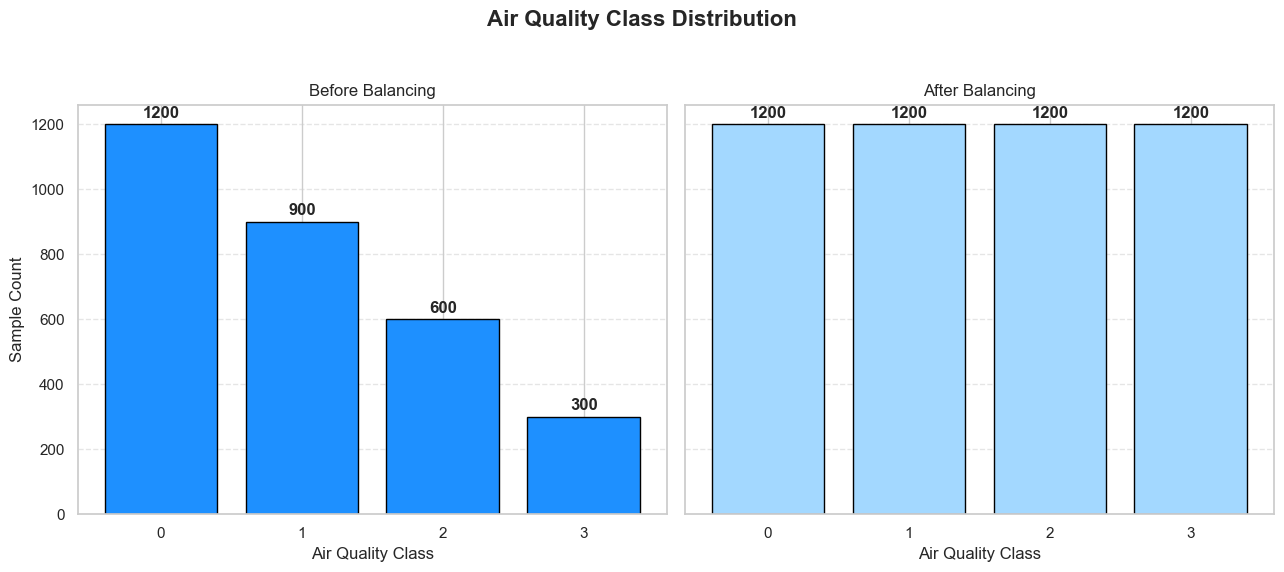

In [59]:
labels = ['0', '1', '2', '3']
before_counts = [1200, 900, 600, 300]
after_counts  = [1200, 1200, 1200, 1200]

before_color = '#1E90FF' 
after_color = '#A3D8FF'
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)


axes[0].bar(labels, before_counts, color=before_color, edgecolor='black', linewidth=1)
axes[0].set_title('Before Balancing')
axes[0].set_xlabel('Air Quality Class')
axes[0].set_ylabel('Sample Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate(before_counts):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

axes[1].bar(labels, after_counts, color=after_color, edgecolor='black', linewidth=1)
axes[1].set_title('After Balancing')
axes[1].set_xlabel('Air Quality Class')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate(after_counts):
    axes[1].text(i, v + 20, str(v), ha='center', fontweight='bold')
plt.suptitle('Air Quality Class Distribution', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Standardizing the Data

In [60]:
scaler = StandardScaler()
features=["Temperature","Humidity","PM2.5","PM10","NO2","SO2","CO","Proximity_to_Industrial_Areas","Population_Density"]
X_train[features]=scaler.fit_transform(X_train[features])
X_valid[features]=scaler.transform(X_valid[features])
X_test[features]=scaler.transform(X_test[features])
X_valid.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
3992,-0.604884,-0.630338,-0.493238,-0.933438,-0.346706,-1.176324,-1.352165,0.924395,-2.031126
2884,-0.681386,-1.980820,0.858075,0.440839,-0.755354,-0.564173,-1.193893,3.606571,-0.432304
2274,0.710940,1.430258,-0.226255,0.239088,0.928838,0.348226,0.632657,-0.892563,0.048592
3309,0.144829,0.193900,-1.274242,-1.158832,-0.049111,0.249905,0.308268,-0.431113,-0.763310
125,0.190730,-1.137561,-1.554683,-2.105239,0.716465,-0.484003,0.128710,0.088017,-0.419813


In [61]:
all_metrics = {}

In [62]:
def evaluate_model(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    model_metrices ={ 
    "accuracy" : accuracy_score(y_valid, y_pred),
    "precision" : precision_score(y_valid, y_pred, average='weighted'),
    "recall" : recall_score(y_valid, y_pred, average='weighted'),
    "f1" : f1_score(y_valid, y_pred, average='weighted'),
    "cm" : confusion_matrix(y_valid, y_pred)
    }
    # print(model_metrices)
    return model_metrices

# SVM

In [63]:
#linear SVM
c_values = [1,2,3,4,5,6,7,8,9,10]
best_valid_acc = float('-inf')
best_svm_linear = None
best_c = 0
for c in c_values:
    svm_linear = SVC(kernel='linear', C=c)
    svm_linear.fit(X_train, y_train)
    y_pred = svm_linear.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    if accuracy > best_valid_acc:
        best_valid_acc = accuracy
        best_svm_linear = svm_linear
        best_c = c
all_metrics["best_svm_linear"] = evaluate_model(best_svm_linear, X_valid, y_valid)
print("optimal c value for linear kernel:", best_c)


#polynomial svm
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4, 5]}
grid_search_poly = GridSearchCV(SVC(kernel='poly'), param_grid, cv=5)
grid_search_poly.fit(X_train, y_train)
print("Best hyperparameters for polynomial kernel:", grid_search_poly.best_params_)
svm_poly = grid_search_poly.best_estimator_
all_metrics["svm_poly"] = evaluate_model(svm_poly, X_valid, y_valid)

#rbf
best_c_rbf = 0
best_svm_rbf = None
best_valid_acc = float('-inf')
for c in c_values:
    svm_rbf = SVC(kernel='rbf', C=c, gamma='scale')
    svm_rbf.fit(X_train, y_train)
    y_pred = svm_rbf.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    if accuracy > best_valid_acc:
        best_valid_acc = accuracy
        best_svm_rbf = svm_rbf
        best_c_rbf = c
all_metrics["best_svm_rbf"] = evaluate_model(best_svm_rbf, X_valid, y_valid)

Best hyperparameters for polynomial kernel: {'C': 1000, 'degree': 5}


In [64]:
print(best_c_rbf)

1


# Logistic Regression

In [65]:
number_of_columns = [2, 3, 4, 5, 6, 7, 8, 9]
epoch_values = [100, 300, 500, 700, 1000]

best_valid_acc = float('-inf')
best_config = {}
best_pca = None 

for epoch in epoch_values:
    for col in number_of_columns:
        
        pca = PCA(n_components=col)
        X_train_pca = pca.fit_transform(X_train)
        X_valid_pca = pca.transform(X_valid)

        model_lr = LogisticRegression(max_iter=epoch, random_state=42)
        model_lr.fit(X_train_pca, y_train)
        y_pred = model_lr.predict(X_valid_pca)

        accuracy = accuracy_score(y_valid, y_pred)

        if accuracy > best_valid_acc:
            best_valid_acc = accuracy
            best_config = {
                'best_model': model_lr,
                'best_n_components': col,
                'best_max_iter': epoch,
                'best_accuracy': accuracy
            }
            best_pca = pca 

X_valid_pca = best_pca.transform(X_valid)
all_metrics["best_lr"] = evaluate_model(best_config['best_model'],X_valid_pca,y_valid)
print("Best hyperparameters for logistic regression:", best_config)


# Plotting weights for Logistic Regression

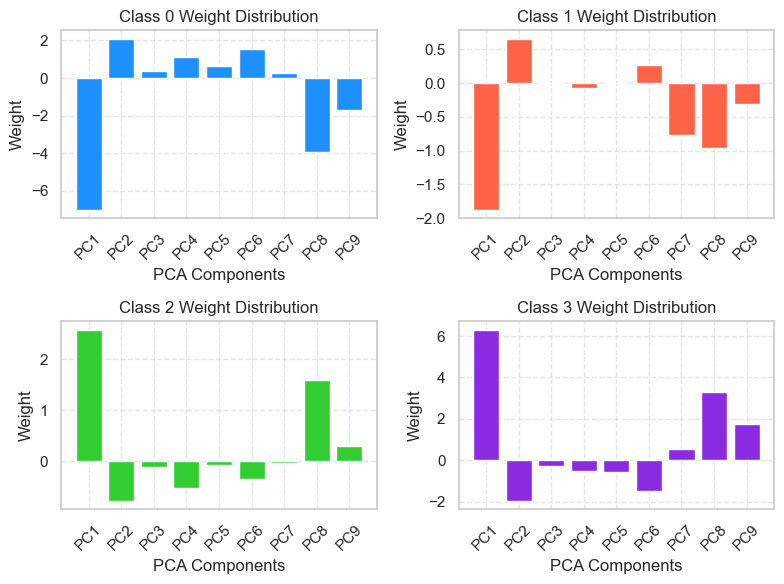

In [66]:
coefs = best_config['best_model'].coef_ 
n_features = coefs.shape[1]
component_labels = [f'PC{i+1}' for i in range(n_features)]
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()
colors = ['#1E90FF', '#FF6347', '#32CD32', '#8A2BE2']
class_labels = best_config['best_model'].classes_  

for i in range(4):
    axs[i].bar(component_labels, coefs[i], color=colors[i])
    axs[i].set_title(f'Class {class_labels[i]} Weight Distribution')
    axs[i].set_ylabel('Weight')
    axs[i].set_xlabel('PCA Components')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# NEURAL NETWORKS

---------------------Validation-----------------



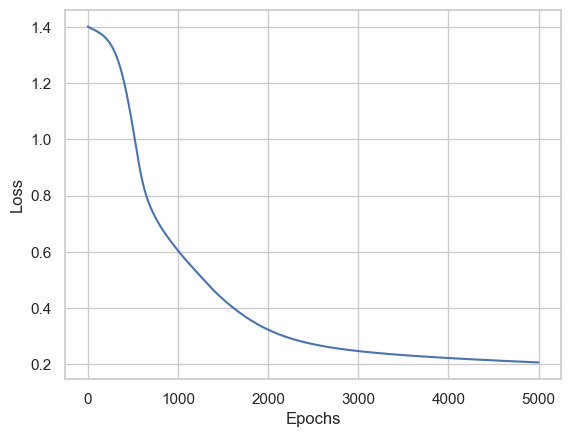

---------------------Validation-----------------



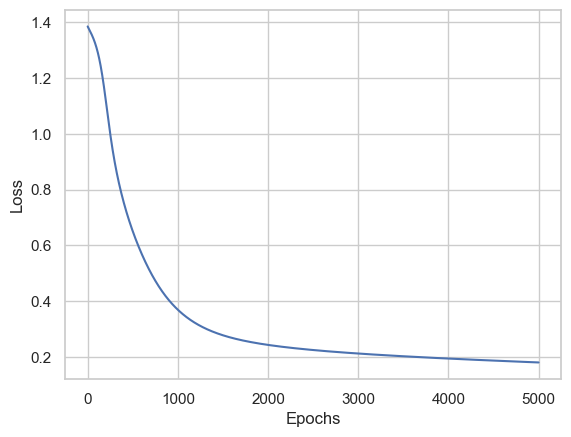

---------------------Validation-----------------



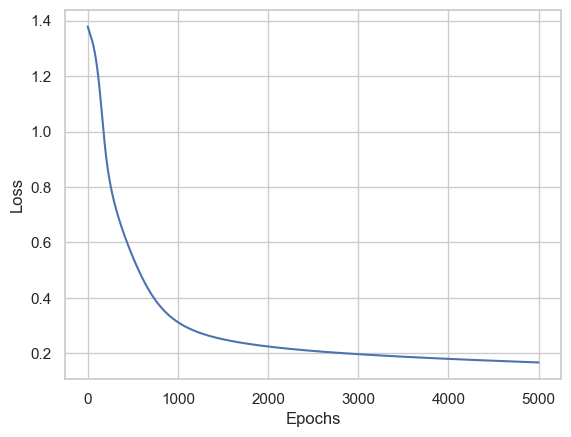

---------------------Validation-----------------



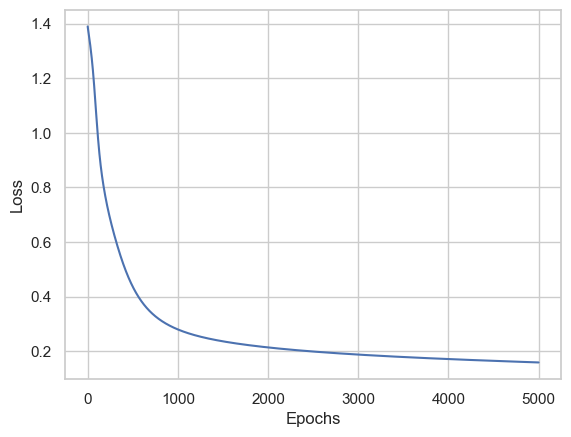

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

X_train_nn = torch.tensor(X_train.values, dtype=torch.float32)
y_train_nn = torch.tensor(y_train.values, dtype=torch.long) 
X_valid_nn = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_nn = torch.tensor(y_valid.values, dtype=torch.long)
X_test_nn = torch.tensor(X_test.values, dtype=torch.float32)
y_test_nn = torch.tensor(y_test.values, dtype=torch.long)

class MultiNeuralNet(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3):
        super(MultiNeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2,hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, 4) 
        )
    
    def forward(self, x):
        return self.layers(x)

def evaluate(X, y):
    model_nn.eval()
    with torch.no_grad():
        y_pred = model_nn(X)
        y_pred = torch.argmax(y_pred, dim=1) 
    y_true = y.numpy()
    y_pred = y_pred.numpy()
    
    return accuracy_score(y_pred,y_true)
def metrics(X,y):
    best_nn.eval()
    with torch.no_grad():
        y_pred = best_nn(X)
        y_pred = torch.argmax(y_pred, dim=1) 
    y_true = y.numpy()
    y_pred = y_pred.numpy()
    
    all_metrics["best_NN"]={
        'cm': confusion_matrix(y_pred,y_valid),
        'accuracy': accuracy_score(y_pred,y_valid),
        'precision': precision_score(y_pred,y_valid,average='weighted'),
        'recall': recall_score(y_pred,y_valid,average='weighted'),
        'f1': f1_score(y_pred,y_valid,average='weighted')
    }

hidden_layers = [[64, 32, 16], [128, 64, 32], [256, 128, 64],[512,256,128]]
criterion = nn.CrossEntropyLoss()
all_losses = []
best_acc_score = float('-inf')
for layer in hidden_layers:
    model_nn = MultiNeuralNet(input_size=9, hidden1=layer[0], hidden2=layer[1],hidden3=layer[2])
    optimizer = optim.SGD(model_nn.parameters(), lr=0.01)
    losses = []
    epochs = 5000
    for epoch in range(epochs + 1):
        model_nn.train()
        optimizer.zero_grad()
        output = model_nn(X_train_nn)
        loss = criterion(output, y_train_nn)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    all_losses.append(losses)
    
    print("---------------------Validation-----------------\n")
    acc_score = evaluate(X_valid_nn, y_valid_nn)
    if(acc_score > best_acc_score):
        best_acc_score = acc_score
        best_nn = model_nn
    
    plt.plot(range(epochs + 1), losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
acc=metrics(X_valid_nn,y_valid_nn)

# KNearestNeighbors

In [68]:
param_grid = {
    'n_neighbors': [3, 5, 7, 11,13,17],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("Best KNN Params:", grid_knn.best_params_)
all_metrics["best_knn"] = evaluate_model(best_knn,X_valid,y_valid)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


#  BAYES CLASSIFIER

In [69]:
class_parametres={}

for c in np.unique(y_train):
    X_c=X_train[y_train==c]
    class_parametres[c]={
        'mean':np.mean(X_c,axis=0),
        'cov':np.cov(X_c,rowvar=False),
        'prior':len(X_c)/len(y_train)
    }
    
def bayes_classifier(X):
    prediction=[]
    for x in X:
        posterior={}
        likelihood={}
        total_prob=0
        for c,paras in class_parametres.items():
            likelihood[c]=multivariate_normal(mean=paras['mean'],cov=paras['cov'],allow_singular=True).pdf(x)
            total_prob+=likelihood[c]*paras['prior']
        for c,paras in class_parametres.items():
            posterior[c]=(likelihood[c]*paras['prior'])/total_prob
            
        prediction.append(max(posterior,key=posterior.get))
    return prediction

y_pred=bayes_classifier(X_valid.values)
all_metrics["bayes"] = {
        "cm" : confusion_matrix(y_valid, y_pred), 
        "accuracy" : accuracy_score(y_valid, y_pred),
        "precision": precision_score(y_valid, y_pred, average='weighted'),
        "recall": recall_score(y_valid, y_pred, average='weighted'),
        "f1": f1_score(y_valid, y_pred, average='weighted')
    }
    

# Naive bayes

In [70]:
navie_bayes = GaussianNB()
navie_bayes.fit(X_train,y_train)
all_metrics["Navie Bayes"] = evaluate_model(navie_bayes,X_valid,y_valid)

# DECISION TREES

best depth 13
Best accuarcy is 0.925


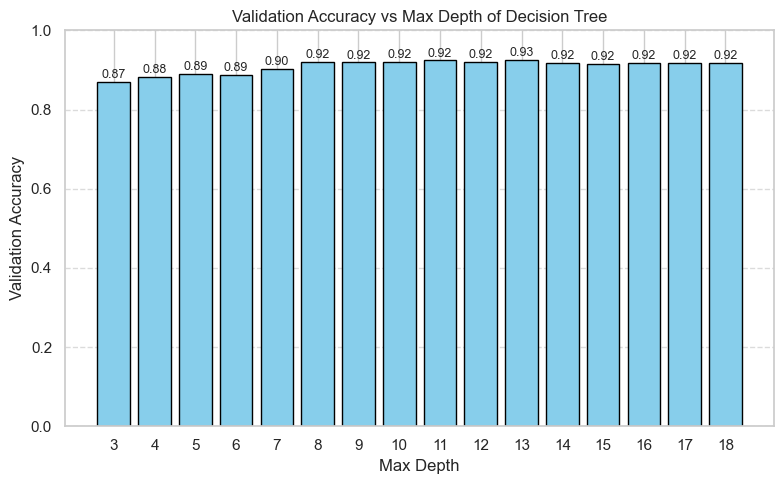

In [71]:
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
train_accuracy = []
valid_accuracy = []
max_valid_accuracy = float('-inf')
best_depth = 0
best_model_dt = 0
for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state= 42)
    model.fit(X_train, y_train)

    train_acc =accuracy_score(model.predict(X_train), y_train) 
    valid_acc = accuracy_score(model.predict(X_valid), y_valid)

    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    if(max_valid_accuracy < valid_acc):
        max_valid_accuracy = valid_acc
        best_depth = depth
        best_model_dt = model
print(f'best depth {best_depth}')
print(f'Best accuarcy is {max_valid_accuracy}')
all_metrics["best_model_dt"] = evaluate_model(best_model_dt,X_valid,y_valid)

plt.figure(figsize=(8, 5))
plt.bar(max_depths, valid_accuracy, color='skyblue', edgecolor='black')

plt.title('Validation Accuracy vs Max Depth of Decision Tree')
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(max_depths)
for i, acc in enumerate(valid_accuracy):
    plt.text(max_depths[i], acc + 0.01, f'{acc:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# RANDOM FOREST


Best Hyperparameters:
{'n_estimators': 50, 'max_depth': 10}
CO                               0.350707
Proximity_to_Industrial_Areas    0.246206
NO2                              0.127349
SO2                              0.091082
Temperature                      0.058515
Population_Density               0.049650
Humidity                         0.039823
PM10                             0.024913
PM2.5                            0.011755
dtype: float64


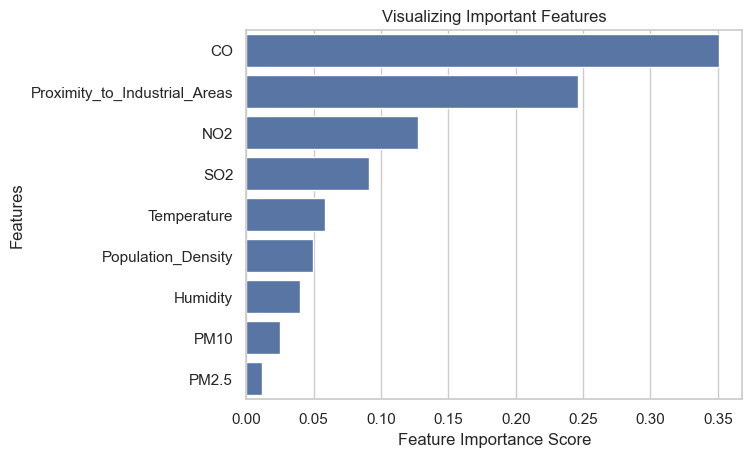

In [72]:
n_estimators_options = [50, 100, 150]
max_depth_options = [10, 20, 30]
best_valid_acc = float('-inf')
best_model_rf = None
best_params = {}

for n in n_estimators_options:
    for depth in max_depth_options:
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42)
        model.fit(X_train, y_train)

        valid_pred = model.predict(X_valid)
        valid_acc = accuracy_score(y_valid, valid_pred)
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_rf = model
            best_params = {"n_estimators": n, "max_depth": depth}

print("\nBest Hyperparameters:")
print(best_params)
all_metrics["best_model_rf"] = evaluate_model(best_model_rf,X_valid,y_valid)

feature_scores = pd.Series(best_model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# By removing 1 least important features

In [73]:
X_train_rf = X_train.drop(['PM2.5'], axis=1)
X_valid_rf = X_valid.drop(['PM2.5'], axis=1)
n_estimators_options = [50, 100, 150]
max_depth_options = [10, 20, 30]
best_valid_acc = float('-inf')
best_model_rf_1 = None
best_params = {}

for n in n_estimators_options:
    for depth in max_depth_options:
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42)
        model.fit(X_train_rf, y_train)

        valid_pred = model.predict(X_valid_rf)
        valid_acc = accuracy_score(y_valid, valid_pred)
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_rf_1 = model
            best_params = {"n_estimators": n, "max_depth": depth}

print("\nBest Hyperparameters:")
print(best_params)
all_metrics["best_model_rf"] = evaluate_model(best_model_rf_1,X_valid_rf,y_valid)


Best Hyperparameters:
{'n_estimators': 150, 'max_depth': 10}


# Printing the metrics of all Models

In [74]:
cleaned_metrics = {}
for model_name, metrics in all_metrics.items():
    filtered_metrics = {k: v for k, v in metrics.items() if k != "cm"}
    cleaned_metrics[model_name] = filtered_metrics
metrics_df = pd.DataFrame.from_dict(cleaned_metrics, orient='index')
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={"index": "Model"}, inplace=True)
name_map = {
    'best_svm_linear': 'SVM (Linear Kernel)',
    'svm_poly': 'SVM (Polynomial)',
    'best_svm_rbf': 'SVM (RBF Kernel)',
    'best_lr': 'Logistic Regression',
    'best_NN': 'Neural Network',
    'best_knn': 'K-Nearest Neighbors',
    'bayes': 'Bayes',
    'Navie Bayes' : 'Navie Bayes',
    'best_model_dt': 'Decision Tree',
    'best_model_rf': 'Random Forest'
}

metrics_df['Model'] = metrics_df['Model'].map(name_map)
print(metrics_df)

                 Model  accuracy  precision  recall        f1
0  SVM (Linear Kernel)     0.938   0.938110   0.938  0.938023
1     SVM (Polynomial)     0.907   0.905042   0.907  0.905478
2     SVM (RBF Kernel)     0.941   0.941128   0.941  0.941037
3  Logistic Regression     0.936   0.936520   0.936  0.936166
4       Neural Network     0.942   0.941617   0.942  0.941735
5  K-Nearest Neighbors     0.920   0.919905   0.920  0.919819
6                Bayes     0.937   0.937519   0.937  0.937177
7          Navie Bayes     0.932   0.932464   0.932  0.932192
8        Decision Tree     0.925   0.924890   0.925  0.924936
9        Random Forest     0.949   0.950459   0.949  0.949365


# Comparison of All models based on Accuracy

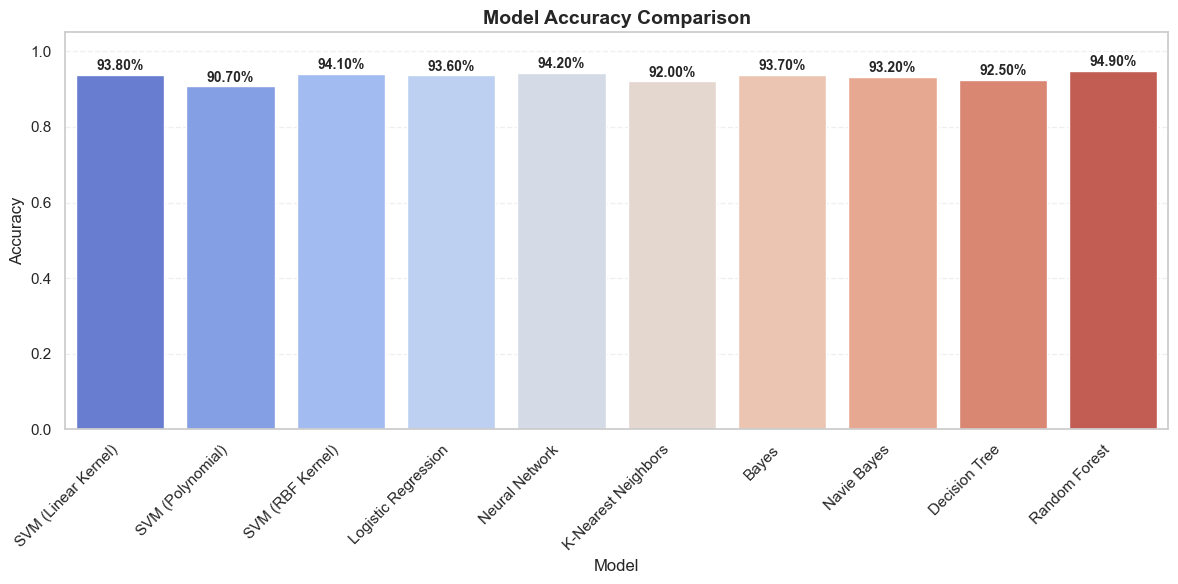

In [75]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='accuracy',hue='Model' ,data=metrics_df, palette='coolwarm')
for index, row in metrics_df.iterrows():
    plt.text(index, row['accuracy'] + 0.005, f"{row['accuracy']*100:.2f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Comparison of All models based on Precision

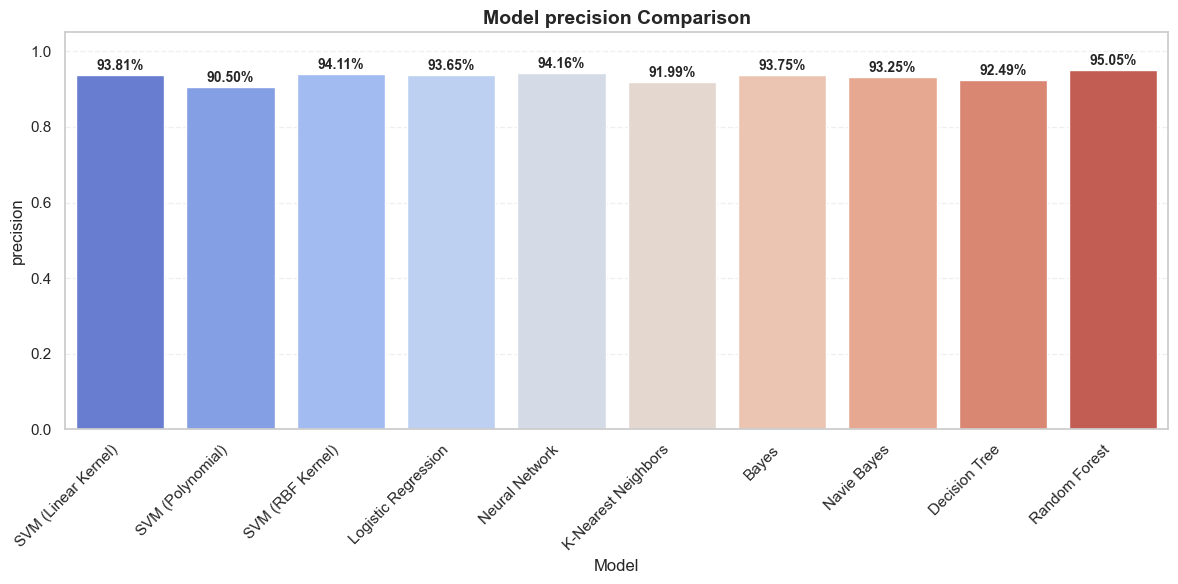

In [76]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='precision',hue='Model' ,data=metrics_df, palette='coolwarm')
for index, row in metrics_df.iterrows():
    plt.text(index, row['precision'] + 0.005, f"{row['precision']*100:.2f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Model precision Comparison', fontsize=14, fontweight='bold')
plt.ylabel('precision')
plt.xlabel('Model')
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Comparison of All models based on Recall

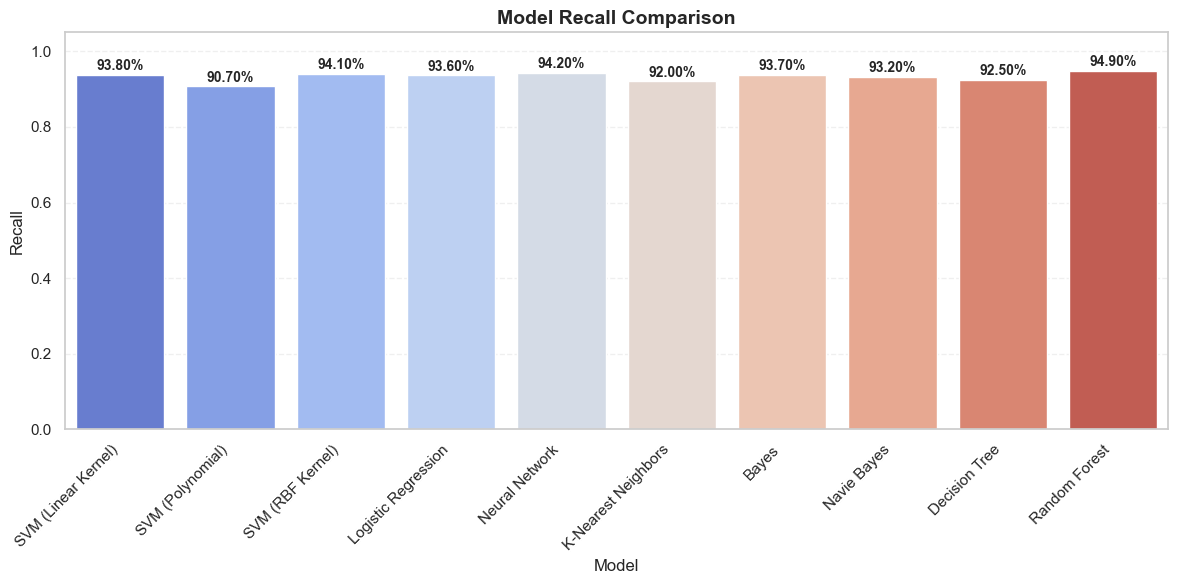

In [77]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='recall',hue='Model' ,data=metrics_df, palette='coolwarm')
for index, row in metrics_df.iterrows():
    plt.text(index, row['recall'] + 0.005, f"{row['recall']*100:.2f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Model Recall Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Comparison of All models based on f1 score

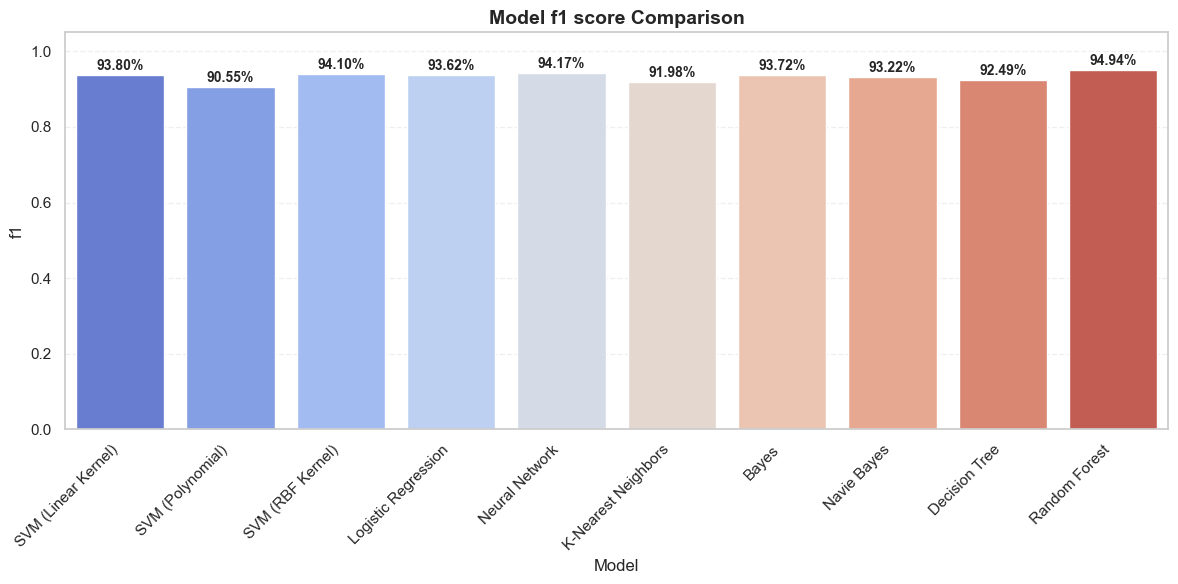

In [78]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='f1',hue='Model' ,data=metrics_df, palette='coolwarm')
for index, row in metrics_df.iterrows():
    plt.text(index, row['f1'] + 0.005, f"{row['f1']*100:.2f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Model f1 score Comparison', fontsize=14, fontweight='bold')
plt.ylabel('f1')
plt.xlabel('Model')
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrix of validation set on all Models


Model: best_svm_linear
Accuracy  : 0.9380
Precision : 0.9381
Recall    : 0.9380
F1 Score  : 0.9380


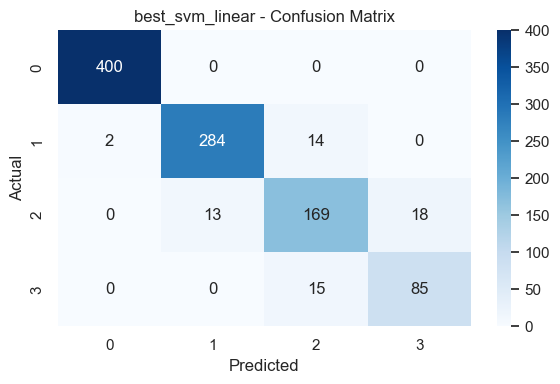

****************************************************************************************************

Model: svm_poly
Accuracy  : 0.9070
Precision : 0.9050
Recall    : 0.9070
F1 Score  : 0.9055


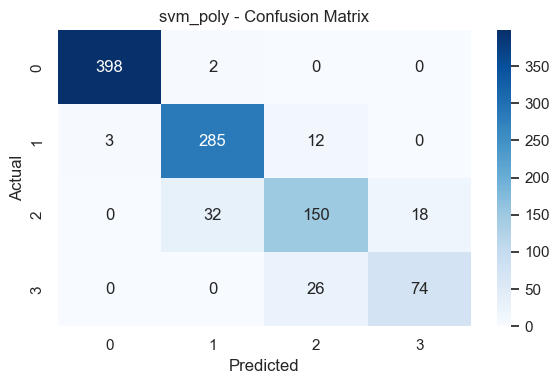

****************************************************************************************************

Model: best_svm_rbf
Accuracy  : 0.9410
Precision : 0.9411
Recall    : 0.9410
F1 Score  : 0.9410


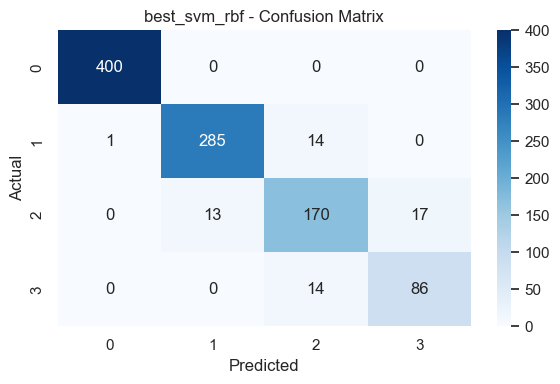

****************************************************************************************************

Model: best_lr
Accuracy  : 0.9360
Precision : 0.9365
Recall    : 0.9360
F1 Score  : 0.9362


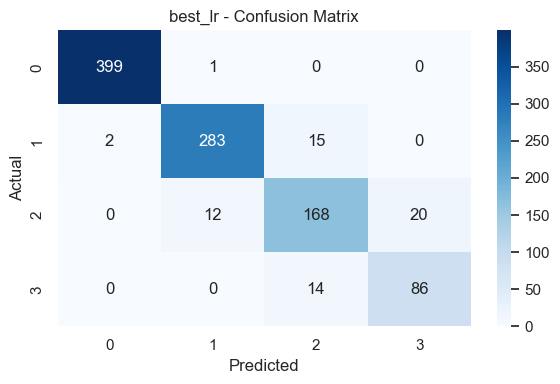

****************************************************************************************************

Model: best_NN
Accuracy  : 0.9420
Precision : 0.9416
Recall    : 0.9420
F1 Score  : 0.9417


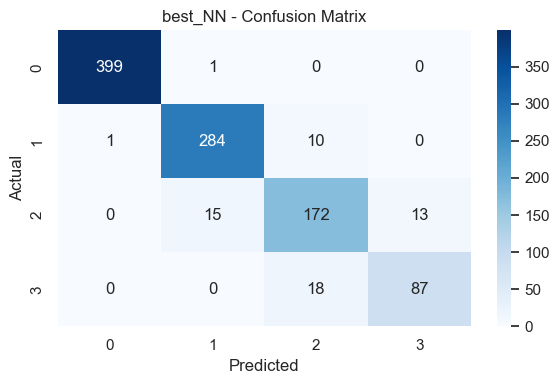

****************************************************************************************************

Model: best_knn
Accuracy  : 0.9200
Precision : 0.9199
Recall    : 0.9200
F1 Score  : 0.9198


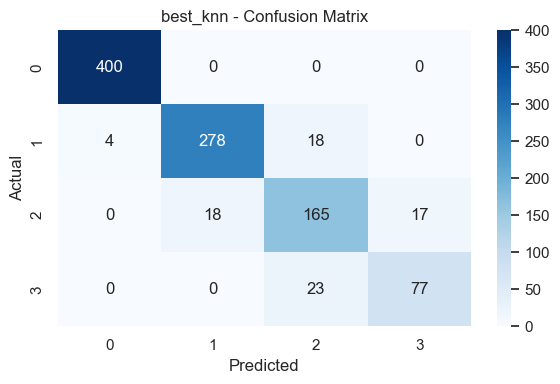

****************************************************************************************************

Model: bayes
Accuracy  : 0.9370
Precision : 0.9375
Recall    : 0.9370
F1 Score  : 0.9372


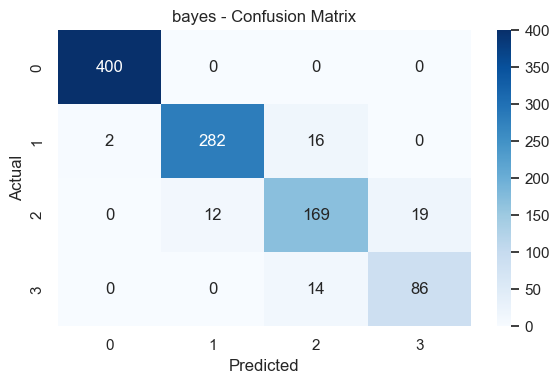

****************************************************************************************************

Model: Navie Bayes
Accuracy  : 0.9320
Precision : 0.9325
Recall    : 0.9320
F1 Score  : 0.9322


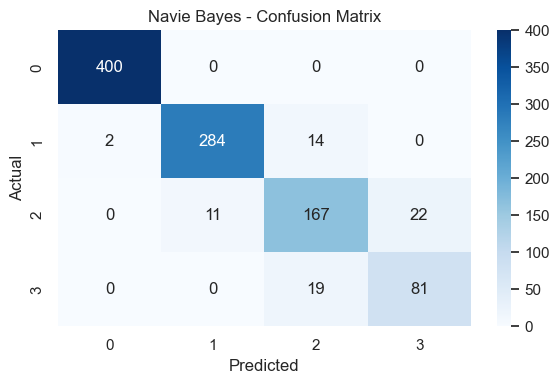

****************************************************************************************************

Model: best_model_dt
Accuracy  : 0.9250
Precision : 0.9249
Recall    : 0.9250
F1 Score  : 0.9249


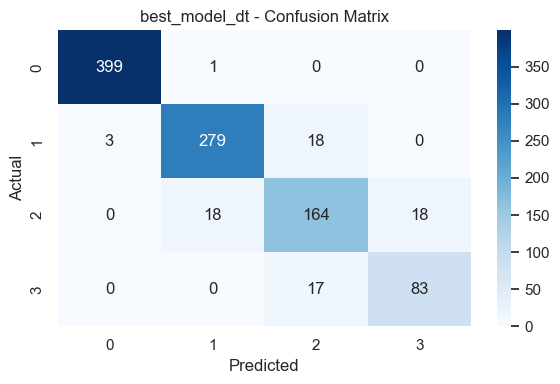

****************************************************************************************************

Model: best_model_rf
Accuracy  : 0.9490
Precision : 0.9505
Recall    : 0.9490
F1 Score  : 0.9494


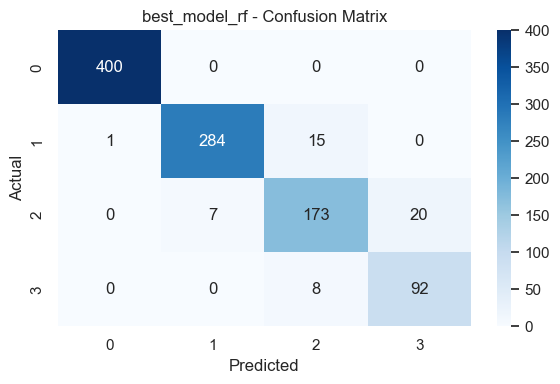

****************************************************************************************************


In [79]:
for model_name, metrics in all_metrics.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy  : {metrics['accuracy']:.4f}")
    print(f"Precision : {metrics['precision']:.4f}")
    print(f"Recall    : {metrics['recall']:.4f}")
    print(f"F1 Score  : {metrics['f1']:.4f}")
    
    # Confusion matrix heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(metrics['cm'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    print('**'*50)

# Evaluation on Test Data by using the best model(Random Forest)

The accuracy on Test data is 0.963
The precision on Test data is 0.9636
The Recall on Test data is 0.963
The F1 score on Test data is 0.9632


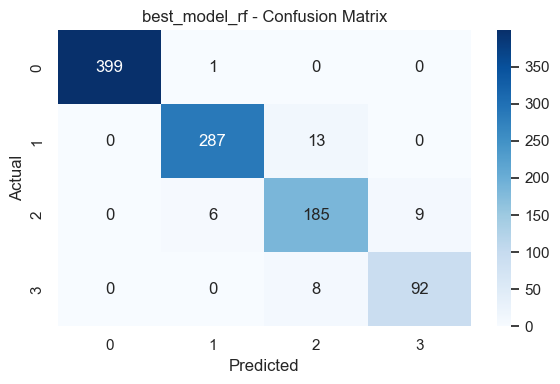

In [80]:
X_test_rf = X_test.drop(['PM2.5'], axis=1)
y_pred_test = best_model_rf_1.predict(X_test_rf)
print(f'The accuracy on Test data is {round(accuracy_score(y_test,y_pred_test),4)}')
print(f'The precision on Test data is {round(precision_score(y_test,y_pred_test,average = 'weighted'),4)}')
print(f'The Recall on Test data is {round(recall_score(y_test,y_pred_test,average = 'weighted'),4)}')
print(f'The F1 score on Test data is {round(f1_score(y_test,y_pred_test,average = 'weighted'),4)}')

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test,y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.title(f"{model_name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()